#Chapter 4 - Building Good Training Datasets – Data Preprocessing

## Dealing with missing data


### Identifying missing values in tabular data

In [59]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''


if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [60]:
df.isnull().sum()

,0
A,0
B,0
C,1
D,1


In [61]:
'''It is recommended to use NumPy arrays when possible.
Note that you can always access the underlying NumPy array of a
DataFrame via the values attribute before you feed it into a scikit-learn estimator'''
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

### Eliminating training examples or features with missing values

In [62]:
# remove rows that contain missing values

df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [63]:
# remove columns that contain missing values

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [64]:
# only drop rows where all columns are NaN

df.dropna(how='all',axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [65]:
# drop rows that have fewer than 4 real values

df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [66]:
# only drop rows where NaN appear in specific columns (here: 'C')

df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


### Imputing missing values

In [67]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [68]:
# impute missing values by mean in each column

from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
# other options:
#-median
#-most_frequent
imr=imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [69]:
# easier with pandas
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


## Handling categorical data

**Ordinal features** can be understood as categorical values that can be sorted or ordered.
For example, t-shirt size would be an ordinal feature, because we can define an order: XL > L > M.

In
contrast, **nominal features** don’t imply any order; to continue with the previous example, we could
think of t-shirt color as a nominal feature since it typically doesn’t make sense to say that, for example,
red is larger than blue.

### Categorical data encoding with pandas

In [70]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


### Mapping ordinal features

In [71]:
size_mapping = {'XL': 3, 'L': 2, 'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [72]:
# How to come back to initial ordinal values
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

,size
0,M
1,L
2,XL


### Encoding class labels

In [73]:
import numpy as np

class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [74]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [75]:
# Reverse
inverted_class_mapping = {v:k for k,v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inverted_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [76]:
#Alternative way - LabelEncoder
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [77]:
# And reverse
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

### One-hot encoding on nominal features

In [78]:
X=df[['color','size','price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X
#blue = 0
#green = 1
#red = 2
#Not good

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [79]:
# Using One-Hot enoder on color column
from sklearn.preprocessing import OneHotEncoder
X = df[['color','size','price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:,0].reshape(-1,1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [80]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In the preceding code example, we specified that we want to modify only the first column and leave
the other two columns untouched via the 'passthrough' argument.

In [81]:
#pandas options - get_dummies() - change only string columns
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,False,True,False
1,13.5,2,False,False,True
2,15.3,3,True,False,False


In [82]:
#drop first option
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,True,False
1,13.5,2,False,True
2,15.3,3,False,False


In [83]:
#Same with OHE
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

### Encoding ordinal features
If we are unsure about the numerical differences between the categories of ordinal features, or the difference between two ordinal values is not defined, we can also encode them using a threshold encoding with 0/1 values. For example, we can split the feature "size" with values M, L, and XL into two new features "x > M" and "x > L". Let's consider the original DataFrame:

In [84]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [85]:
df['x>M'] = df['size'].apply(lambda x: 1 if x in {'L','XL'} else 0)
df['x>L'] = df['size'].apply(lambda x: 1 if x == "XL" else 0)
del df['size']
df

,color,price,classlabel,x>M,x>L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


## Partitioning a dataset into a separate training and test set

In [86]:
#importing wine dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [87]:
df_wine.columns=['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [88]:
# Splitting dataset
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

Providing
the class label array y as an argument to stratify ensures that both training and test datasets have
the same class proportions as the original dataset.

### Bringing features onto the same scale

Normalization: x(norm) = (x - x(min))/(x(max)-x(min))

Standardization:
x(std) = ((x - mean(xcol)))/std(xcol)

In [89]:
# Min-Max Scaling - normalization
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)
X_test_norm[0]

array([0.69005848, 0.22924901, 0.64052288, 0.30645161, 0.55555556,
       0.69655172, 0.51687764, 0.52      , 0.39873418, 0.40497336,
       0.69148936, 0.60805861, 0.78245364])

In [90]:
#Standardization:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_test_std[0]

array([ 0.89443737, -0.38811788,  1.10073064, -0.81201711,  1.13201117,
        1.09807851,  0.71204102,  0.18101342,  0.06628046,  0.51285923,
        0.79629785,  0.44829502,  1.90593792])

Comparing the results

In [91]:
example = np.array([0,1,2,3,4,5])
print('standardized:', (example - example.mean()) / example.std())
print("----")
print('normalized:', (example - example.min()) / (example.max() - example.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
----
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


Again, it is also important to highlight that we fit the StandardScaler class only once—on the training
data—and use those parameters to transform the test dataset or any new data point.

Other, more advanced methods for feature scaling are available from scikit-learn, such as RobustScaler. RobustScaler is especially helpful and recommended if we are working with small datasets that
contain many outliers. Similarly, if the machine learning algorithm applied to this dataset is prone
to overfitting, RobustScaler can be a good choice. Operating on each feature column independently,
RobustScaler removes the median value and scales the dataset according to the 1st and 3rd quartile of
the dataset (that is, the 25th and 75th quantile, respectively) such that more extreme values and outliers
become less pronounced.

## Selecting meaningful features

**Overfitting - high variance**

Common solutions to reduce the generalization error are as follows:

• Collect more training data

• Introduce a penalty for complexity via regularization

• Choose a simpler model with fewer parameters

• Reduce the dimensionality of the data

### L1 and L2 regularization as penalties against model complexity

For regularized models in scikit-learn that support L1 regularization, we can simply set the penalty parameter to 'l1' to obtain a sparse solution:

In [92]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1',
                   solver='liblinear',
                   multi_class='ovr')

LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear')

Note that we also need to select a different optimization algorithm (for example, solver='liblinear'),
since 'lbfgs' currently does not support L1-regularized loss optimization. Applied to the standardized
Wine data, the L1 regularized logistic regression would yield the following sparse solution:

In [93]:
lr = LogisticRegression(penalty='l1',
                        C=1.0,
                   solver='liblinear',
                   multi_class='ovr')
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('-'*20)
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
--------------------
Test accuracy: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [94]:
# looking at intercept - punkt przecięcia prostej z osią współrzędnych
lr.intercept_


array([-1.26307151, -1.21573955, -2.36993663])

Since we fit the LogisticRegression object on a multiclass dataset via the one-versus-rest (OvR)
approach, the first intercept belongs to the model that fits class 1 versus classes 2 and 3, the second
value is the intercept of the model that fits class 2 versus classes 1 and 3, and the third value is the
intercept of the model that fits class 3 versus classes 1 and 2:

In [95]:
lr.coef_

array([[ 1.24553653,  0.18045864,  0.74199309, -1.15986563,  0.        ,
         0.        ,  1.17430874,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54214799,  2.51113648],
       [-1.53770661, -0.38695074, -0.99543996,  0.36470555, -0.05937898,
         0.        ,  0.66830105,  0.        ,  0.        , -1.93385137,
         1.23371565,  0.        , -2.23186396],
       [ 0.13550711,  0.16860334,  0.35729365,  0.        ,  0.        ,
         0.        , -2.43760189,  0.        ,  0.        ,  1.56385622,
        -0.81895921, -0.49255381,  0.        ]])

The weight array that we accessed via the lr.coef_ attribute contains three rows of weight coefficients,
one weight vector for each class. Each row consists of 13 weights, where each weight is multiplied by
the respective feature in the 13-dimensional Wine dataset to calculate the net input:

**In scikit-learn, intercept_ corresponds to the bias unit and coef_ corresponds to the
values wj.**

In the last example on regularization in this chapter, we will vary the regularization strength and plot
the regularization path—the weight coefficients of the different features for different regularization
strengths:

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

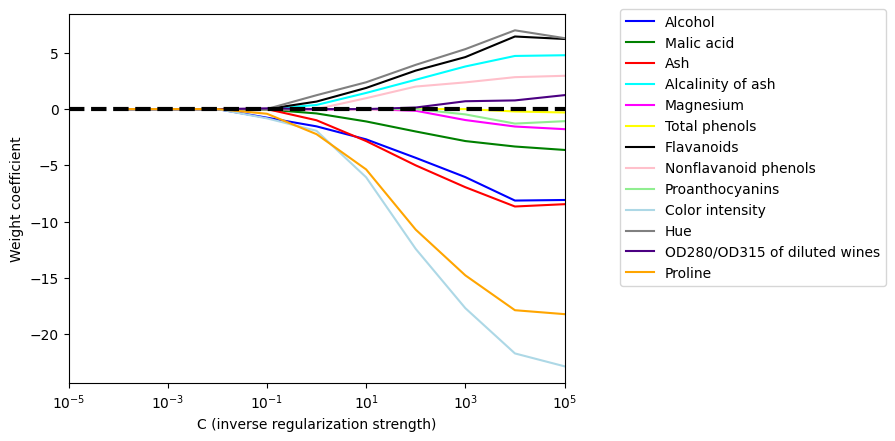

In [96]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear',
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)


plt.show()

The resulting plot provides us with further insights into the behavior of L1 regularization. As we can
see, all feature weights will be zero if we penalize the model with a strong regularization parameter
(C < 0.01); C is the inverse of the regularization parameter, 𝜆

### Sequential feature selection algorithms

#### Python implementation of SBS ( sequential backward selection )
Steps:

1. Initialize the algorithm with k = d, where d is the dimensionality of the full feature space, Xd.

2. Determine the feature, x–, that maximizes the criterion: x– = argmax J(Xk – x), where 𝒙 belongs to Xk

3. Remove the feature, x–, from the feature set: Xk–1 = Xk – x–; k = k – 1.

4. Terminate if k equals the number of desired features; otherwise, go to step 2.

In [97]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS:
  def __init__(self, estimator, k_features,
               scoring=accuracy_score,
               test_size=0.25,random_state=1):
    self.estimator = clone(estimator)
    self.scoring = scoring
    self.k_features = k_features
    self.test_size = test_size
    self.random_state = random_state

  def fit(self, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    dim = X_train.shape[1]
    self.indices_ = tuple(range(dim))
    self.subsets_ = [self.indices_]
    score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
    self.scores_ = [score]
    while dim > self.k_features:
      scores = []
      subsets = []

      for p in combinations(self.indices_, r=dim - 1): # Wypluje wszystkie kombinacje o rozmiarze o 1 mniejszym i zobaczy kiedy najlepszy wynik
        score = self._calc_score(X_train, y_train, X_test, y_test, p)
        scores.append(score)
        subsets.append(p)

      best = np.argmax(scores)
      self.indices_ = subsets[best]
      self.subsets_.append(self.indices_)
      dim -= 1

      self.scores_.append(scores[best])
    self.k_score_ = self.scores_[-1]

    return self

  def transform(self, X):
      return X[:, self.indices_]

  def _calc_score(self, X_train, y_train, X_test, y_test, indices):
      self.estimator.fit(X_train[:, indices], y_train)
      y_pred = self.estimator.predict(X_test[:, indices])
      score = self.scoring(y_test, y_pred)
      return score

Now, let’s see our SBS implementation in action using the KNN classifier from scikit-learn:


In [98]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

Remember that our SBS algorithm collects the scores of the best feature subset at each stage, so let’s
move on to the more exciting part of our implementation and plot the classification accuracy of the
KNN classifier that was calculated on the validation dataset. The code is as follows:

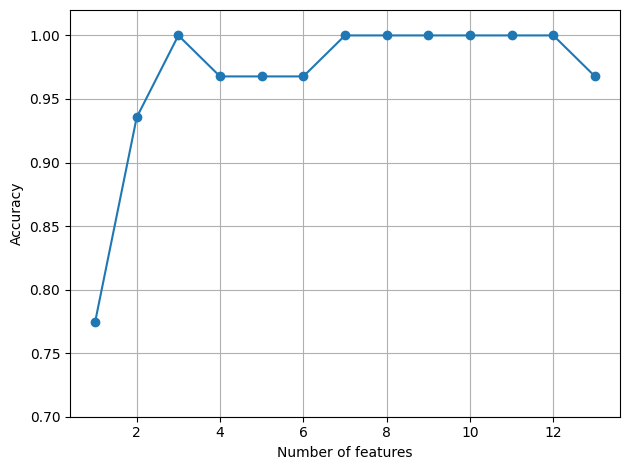

In [99]:
k_feat = [len(k) for k in sbs.subsets_]
#print(k_feat)

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

Ww can see in the
plot that the classifier achieved 100 percent accuracy for k = {3, 7, 8, 9, 10, 11, 12}. To satisfy our own curiosity, let’s see what the smallest feature subset (k=3), which yielded such a good
performance on the validation dataset, looks like

In [100]:
k3 = list(sbs.subsets_[13-3])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


Next, let’s evaluate the performance of the KNN classifier on the original test dataset:

In [102]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


Now, let’s use the selected three-feature
subset and see how well KNN performs:



In [104]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


## Assessing feature importance with random forests

We will now train a forest of 500 trees on the Wine dataset and rank the
13 features by their respective importance measures—remember from our discussion in Chapter 3 that
we don’t need to use standardized or normalized features in tree-based models

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


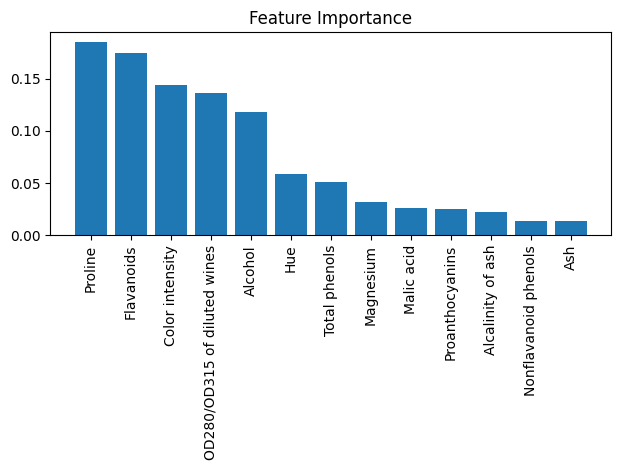

In [105]:
from sklearn.ensemble import RandomForestClassifier
feat_labels=df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

To conclude this section about feature importance values and random forests, it is worth mentioning
that scikit-learn also implements a SelectFromModel object that selects features based on a user-specified
threshold after model fitting, which is useful if we want to use the RandomForestClassifier as
a feature selector and intermediate step in a scikit-learn Pipeline object, which allows us to connect
different preprocessing steps with an estimator, as you will see in Chapter 6, Learning Best Practices
for Model Evaluation and Hyperparameter Tuning. For example, we could set the threshold to 0.1 to
reduce the dataset to the five most important features using the following code:

In [106]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:',
      X_selected.shape[1])

Number of features that meet this threshold criterion: 5


**SelectFromModel(forest, threshold=0.1, prefit=True)**
- forest – Model RandomForestClassifier, który został wcześniej wytrenowany.

- threshold=0.1 – Wybieramy tylko te cechy, których ważność (feature importance) jest większa niż 0.1.

- prefit=True – Oznacza, że model został już wytrenowany, więc SelectFromModel użyje istniejących wartości ważności cech (feature_importances_) bez potrzeby ponownego trenowania.

Now, let's print the 3 features that met the threshold criterion for feature selection that we set earlier:

In [107]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
